In [43]:
import pandas as pd
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns



In [2]:
load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME")

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

In [3]:
df = pd.read_sql("""
   SELECT
    lh.played_at,
    lh.track_id,
    t.name AS track_name,
    STRING_AGG(ar.name, ', ' ORDER BY ar.name) AS artist_names
FROM listening_history lh
JOIN tracks t          ON lh.track_id = t.track_id
JOIN track_artists ta  ON t.track_id = ta.track_id
JOIN artists ar        ON ta.artist_id = ar.artist_id
GROUP BY
    lh.played_at,
    lh.track_id,
    t.name
ORDER BY lh.played_at;
""", engine)

df["played_at"] = pd.to_datetime(df["played_at"])
df["prev_played_at"] = df["played_at"].shift()
df["gap_min"] = (df["played_at"] - df["prev_played_at"]).dt.total_seconds() / 60

df["new_session"] = (df["gap_min"] > 30) | df["gap_min"].isna()
df["session_id"] = df["new_session"].cumsum()

df.head()

,played_at,track_id,track_name,artist_names,prev_played_at,gap_min,new_session,session_id
0,2025-11-23 22:42:27.966000+00:00,27w0RH5IDt6xU3B2j7QOuy,Favourite,"Fontaines D.C., Fontaines D.C.",NaT,NaN,True,1
1,2025-11-24 00:16:50.691000+00:00,4tufTboQdQbmfTnTu5m7l2,Once You Know,"Good Morning, Good Morning",2025-11-23 22:42:27.966000+00:00,94.378750,True,2
2,2025-11-24 00:18:38.326000+00:00,4tufTboQdQbmfTnTu5m7l2,Once You Know,"Good Morning, Good Morning",2025-11-24 00:16:50.691000+00:00,1.793917,False,2
3,2025-11-24 00:23:58.035000+00:00,1tJEdsmqcWGSRDM9uU4a67,Gone for Good - 2023 Remaster,"The Shins, The Shins",2025-11-24 00:18:38.326000+00:00,5.328483,False,2
4,2025-11-24 00:27:29.478000+00:00,1ONbm7r4k4SwGm0Dam487O,Games,"Flycatcher, Flycatcher",2025-11-24 00:23:58.035000+00:00,3.524050,False,2


In [4]:
# convert played_at to datetime
df["played_at"] = pd.to_datetime(df["played_at"])
df = df.sort_values("played_at").reset_index(drop=True)


In [5]:
# define a new session when gap is more than 30 minutes
df["prev_played_at"] = df["played_at"].shift()
df["gap_min"] = (df["played_at"] - df["prev_played_at"]).dt.total_seconds() / 60
df["new_session"] = (df["gap_min"] > 30) | df["gap_min"].isna()
df["session_id"] = df["new_session"].cumsum()

In [6]:
#Engineer session features

session_df = (
    df.groupby("session_id")
      .agg(
          tracks_played=("track_id", "count"),
          unique_tracks=("track_id", "nunique"),
          session_start=("played_at", "min"),
          session_end=("played_at", "max"),
      )
)

session_df["session_duration_min"] = (
    (session_df["session_end"] - session_df["session_start"])
    .dt.total_seconds() / 60
)

session_df["start_hour"] = session_df["session_start"].dt.hour


In [7]:
session_df["repeat_ratio"] = (
    1 - session_df["unique_tracks"] / session_df["tracks_played"]
)


In [10]:
session_df.head()

,tracks_played,unique_tracks,session_start,session_end,session_duration_min,start_hour,repeat_ratio
session_id,,,,,,,
1,1,1,2025-11-23 22:42:27.966000+00:00,2025-11-23 22:42:27.966000+00:00,0.000000,22,0.000000
2,6,5,2025-11-24 00:16:50.691000+00:00,2025-11-24 00:36:46.860000+00:00,19.936150,0,0.166667
3,4,4,2025-11-24 04:55:37.406000+00:00,2025-11-24 05:10:22.426000+00:00,14.750333,4,0.000000
4,3,2,2025-11-24 13:30:27.881000+00:00,2025-11-24 13:42:23.328000+00:00,11.924117,13,0.333333
5,1,1,2025-11-24 17:15:39.948000+00:00,2025-11-24 17:15:39.948000+00:00,0.000000,17,0.000000


**Select and scale features**

In [8]:
features = [
    "tracks_played",
    "unique_tracks",
    "session_duration_min",
    "start_hour",
    "repeat_ratio",
]

X = session_df[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Choose number of clusters**

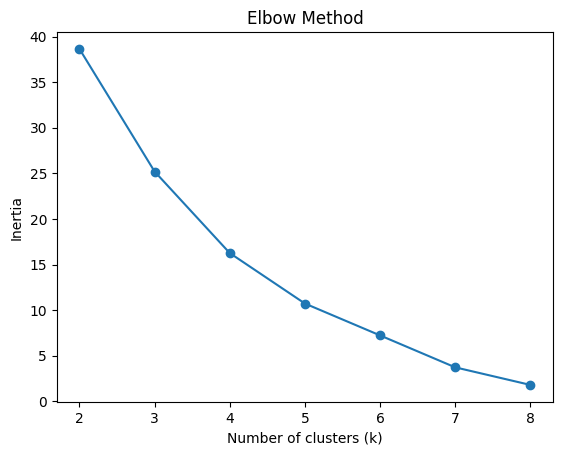

k=2: silhouette=0.366
k=3: silhouette=0.392
k=4: silhouette=0.415
k=5: silhouette=0.403
k=6: silhouette=0.378


In [13]:
inertia = []
k_range = range(2, 9)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Silhouette scores
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: silhouette={score:.3f}")


No immediately noticeable elbow. 

Highest shilhouette score --> k=4

**Fit K-means for k = 4**

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
session_df["cluster"] = kmeans.fit_predict(X_scaled)

**Interpretting the clusters**

In [15]:
cluster_summary = (
    session_df
    .groupby("cluster")[features]
    .mean()
    .round(2)
)

cluster_summary


,tracks_played,unique_tracks,session_duration_min,start_hour,repeat_ratio
cluster,,,,,
0,1.43,1.43,1.88,15.86,0.00
1,5.33,5.00,18.68,2.00,0.06
2,7.00,6.33,61.31,18.00,0.07
3,3.00,2.00,11.92,13.00,0.33


**CLuster Labels**

In [16]:
cluster_labels = {
    0: "Quick check-ins",
    1: "Late-night focused sessions",
    2: "Extended immersive listening",
    3: "Comfort / repeat listening",
}

session_df["cluster_label"] = session_df["cluster"].map(cluster_labels)



In [17]:
# sanity check
session_df[["cluster", "cluster_label"]].drop_duplicates()


,cluster,cluster_label
session_id,,
1,0,Quick check-ins
2,1,Late-night focused sessions
4,3,Comfort / repeat listening
8,2,Extended immersive listening


In [18]:
df = df.merge(
    session_df[["cluster_label"]],
    left_on="session_id",
    right_index=True,
    how="left"
)

**Inspecting sessions by label**

In [20]:
df.groupby("cluster_label")["track_id"].count()


cluster_label
Comfort / repeat listening       3
Extended immersive listening    21
Late-night focused sessions     16
Quick check-ins                 10
Name: track_id, dtype: int64

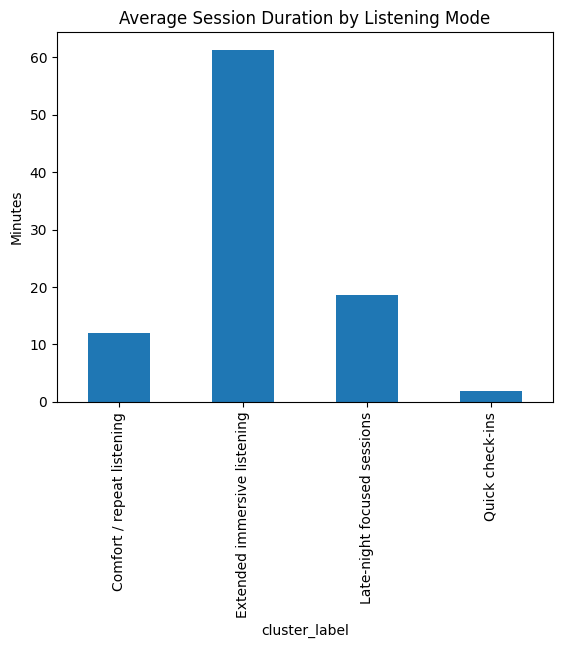

In [21]:
session_df.groupby("cluster_label")["session_duration_min"].mean().plot(
    kind="bar",
    title="Average Session Duration by Listening Mode"
)
plt.ylabel("Minutes")
plt.show()

After clustering listening sessions using KMeans, I assigned interpretable behavioral labels to each cluster based on session duration, repetition patterns, and time-of-day. This allowed me to analyze how different listening modes (e.g., quick check-ins vs immersive sessions) contribute to overall music consumption.

**Which artists dominate each type of session?**

In [23]:
df.columns

Index(['played_at', 'track_id', 'track_name', 'artist_names', 'prev_played_at',
       'gap_min', 'new_session', 'session_id', 'cluster_label'],
      dtype='object')

In [ ]:
# plays per cluster per artist

artist_cluster_df = (
    df.assign(artist=df["artist_names"].str.split(", "))
      .explode("artist")
      .groupby(["cluster_label", "artist"])
      .size()
      .reset_index(name="plays")
)
artist_cluster_df.head(10)


,cluster_label,artist,plays
0,Comfort / repeat listening,Dave Matthews Band,2
1,Comfort / repeat listening,The Brook & The Bluff,4
2,Extended immersive listening,24thankyou,2
3,Extended immersive listening,Band of Horses,2
4,Extended immersive listening,Electric Wizard,2
5,Extended immersive listening,Flawed Mangoes,2
6,Extended immersive listening,Geskle,2
7,Extended immersive listening,Kurt Vile,2
8,Extended immersive listening,MJ Lenderman,6
9,Extended immersive listening,Nirvana,6


In [25]:
# top artists per cluster
top_artists_by_cluster = (
    artist_cluster_df
    .sort_values(["cluster_label", "plays"], ascending=[True, False])
    .groupby("cluster_label")
    .head(10)
)

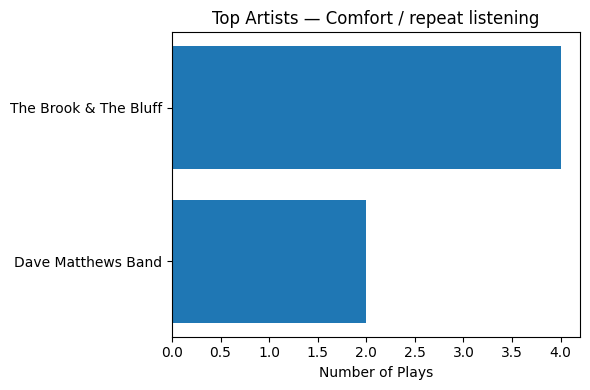

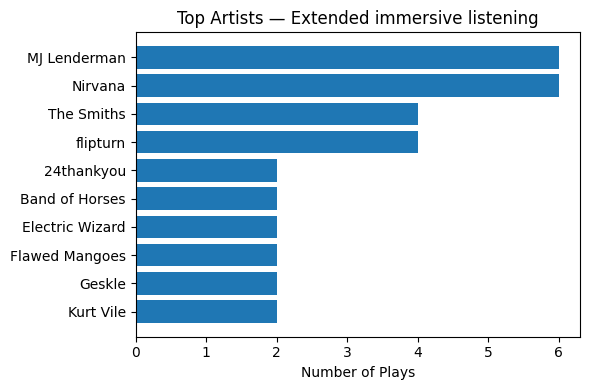

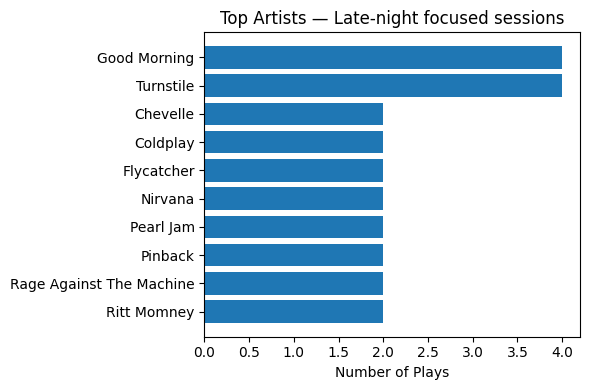

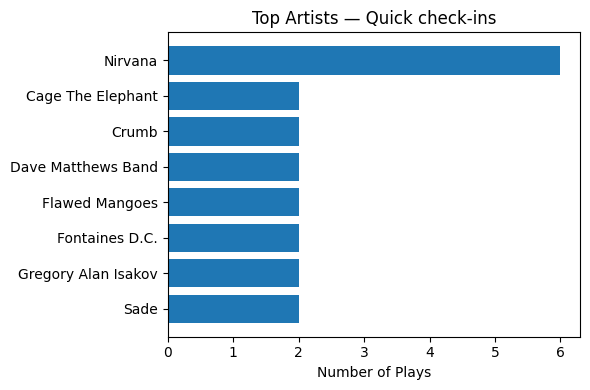

In [26]:
for label in top_artists_by_cluster["cluster_label"].unique():
    subset = top_artists_by_cluster[
        top_artists_by_cluster["cluster_label"] == label
    ]

    plt.figure(figsize=(6, 4))
    plt.barh(subset["artist"], subset["plays"])
    plt.title(f"Top Artists — {label}")
    plt.xlabel("Number of Plays")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

**Measure concentration**

In [27]:
concentration = (
    artist_cluster_df
    .groupby("cluster_label")
    .apply(
        lambda x: x.sort_values("plays", ascending=False)
                    .head(3)["plays"].sum() / x["plays"].sum()
    )
    .reset_index(name="top_3_artist_share")
)

concentration


C:\Users\mason\AppData\Local\Temp\ipykernel_18604\2832347856.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,cluster_label,top_3_artist_share
0,Comfort / repeat listening,1.000000
1,Extended immersive listening,0.380952
2,Late-night focused sessions,0.312500
3,Quick check-ins,0.500000


After labeling listening-session clusters, I analyzed artist dominance within each listening mode. Comfort-oriented sessions were highly concentrated among a small number of familiar artists, while immersive sessions exhibited a broader artist distribution, indicating exploratory or album-focused listening behavior.

**Grouping artists into behavioral categories**

In [28]:
# build artist level features
artist_df = (
    df.assign(artist=df["artist_names"].str.split(", "))
      .explode("artist")
      .groupby("artist")
      .agg(
          total_plays=("track_id", "count"),
          unique_tracks=("track_id", "nunique"),
          first_play=("played_at", "min"),
          last_play=("played_at", "max"),
          active_days=("played_at", lambda x: x.dt.date.nunique()),
      )
      .reset_index()
)
artist_df["span_days"] = (
    artist_df["last_play"] - artist_df["first_play"]
).dt.days

artist_df["plays_per_day"] = (
    artist_df["total_plays"] / artist_df["active_days"]
)
artist_df.head()

,artist,total_plays,unique_tracks,first_play,last_play,active_days,span_days,plays_per_day
0,24thankyou,2,1,2025-11-26 14:13:48.621000+00:00,2025-11-26 14:13:48.621000+00:00,1,0,2.0
1,Band of Horses,2,1,2025-11-25 18:39:26.086000+00:00,2025-11-25 18:39:26.086000+00:00,1,0,2.0
2,Cage The Elephant,2,1,2025-11-26 18:16:00.312000+00:00,2025-11-26 18:16:00.312000+00:00,1,0,2.0
3,Chevelle,2,1,2025-11-25 02:19:49.698000+00:00,2025-11-25 02:19:49.698000+00:00,1,0,2.0
4,Coldplay,2,1,2025-11-24 05:06:04.990000+00:00,2025-11-24 05:06:04.990000+00:00,1,0,2.0


In [29]:
# Select and scale features
features = [
    "total_plays",
    "unique_tracks",
    "active_days",
    "span_days",
    "plays_per_day",
]

X = artist_df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Choosing number of clusters**

In [ ]:

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: silhouette={score:.3f}")

k=2: silhouette=0.829
k=3: silhouette=0.825
k=4: silhouette=0.875
k=5: silhouette=0.881
k=6: silhouette=0.839


While k=5 produced the highest silhouette score, I selected k=4 to balance quantitative performance with interpretability. The four clusters corresponded cleanly to distinct behavioral artist categories.

In [31]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
artist_df["cluster"] = kmeans.fit_predict(X_scaled)


In [33]:
# summary
artist_cluster_summary = (
    artist_df
    .groupby("cluster")[features]
    .mean()
    .round(2)
)
artist_cluster_summary

,total_plays,unique_tracks,active_days,span_days,plays_per_day
cluster,,,,,
0,4.33,1.5,1.0,0.0,4.33
1,5.00,2.5,2.0,1.0,2.50
2,2.00,1.0,1.0,0.0,2.00
3,14.00,7.0,2.0,1.0,7.00


In [36]:
artist_cluster_labels = {
    0: "Burst-listened artists",        # intense, short span (e.g. Nirvana)
    1: "Short-term interests",           # 3–6 plays over 1–2 days
    2: "Light exploration",              # 1–2 plays, single day
    3: "Core rotation artists",           # sustained engagement (if present)
}

artist_df["artist_cluster_label"] = artist_df["cluster"].map(artist_cluster_labels)



In [37]:
for label in artist_cluster_labels.values():
    print(f"\n{label}")
    display(
        artist_df[artist_df["artist_cluster_label"] == label]
        .sort_values("total_plays", ascending=False)
        .head(8)[["artist", "total_plays", "active_days", "span_days"]]
    )



Burst-listened artists


,artist,total_plays,active_days,span_days
15,MJ Lenderman,6,1,0
6,Dave Matthews Band,4,1,0
12,Good Morning,4,1,0
25,The Brook & The Bluff,4,1,0
30,The Smiths,4,1,0
31,Turnstile,4,1,0



Short-term interests


,artist,total_plays,active_days,span_days
33,flipturn,6,2,1
8,Flawed Mangoes,4,2,1



Light exploration


,artist,total_plays,active_days,span_days
0,24thankyou,2,1,0
1,Band of Horses,2,1,0
2,Cage The Elephant,2,1,0
3,Chevelle,2,1,0
4,Coldplay,2,1,0
5,Crumb,2,1,0
7,Electric Wizard,2,1,0
9,Flycatcher,2,1,0



Core rotation artists


,artist,total_plays,active_days,span_days
16,Nirvana,14,2,1


Artist clusters were defined using behavioral engagement features rather than raw popularity. This revealed a burst-listening pattern, where some highly played artists were consumed intensively over short periods rather than revisited consistently over time.

**Mapping artist clusters**

In [40]:
#explode artists and merge with artist df
df_artists = (
    df.assign(artist=df["artist_names"].str.split(", "))
      .explode("artist")
      .merge(
          artist_df[["artist", "artist_cluster_label"]],
          on="artist",
          how="left"
      )
)
df_artists[["cluster_label", "artist", "artist_cluster_label"]].head(10)


,cluster_label,artist,artist_cluster_label
0,Quick check-ins,Fontaines D.C.,Light exploration
1,Quick check-ins,Fontaines D.C.,Light exploration
2,Late-night focused sessions,Good Morning,Burst-listened artists
3,Late-night focused sessions,Good Morning,Burst-listened artists
4,Late-night focused sessions,Good Morning,Burst-listened artists
5,Late-night focused sessions,Good Morning,Burst-listened artists
6,Late-night focused sessions,The Shins,Light exploration
7,Late-night focused sessions,The Shins,Light exploration
8,Late-night focused sessions,Flycatcher,Light exploration
9,Late-night focused sessions,Flycatcher,Light exploration


**Building the cross tab**

In [41]:
cross_tab = (
    df_artists
    .groupby(["cluster_label", "artist_cluster_label"])
    .size()
    .reset_index(name="plays")
)
pivot = cross_tab.pivot(
    index="cluster_label",
    columns="artist_cluster_label",
    values="plays"
).fillna(0)

pivot


artist_cluster_label,Burst-listened artists,Core rotation artists,Light exploration,Short-term interests
cluster_label,,,,
Comfort / repeat listening,6.0,0.0,0.0,0.0
Extended immersive listening,10.0,6.0,20.0,6.0
Late-night focused sessions,8.0,2.0,20.0,2.0
Quick check-ins,2.0,6.0,10.0,2.0


**Normalize**

In [42]:
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0).round(3)
pivot_pct


artist_cluster_label,Burst-listened artists,Core rotation artists,Light exploration,Short-term interests
cluster_label,,,,
Comfort / repeat listening,1.000,0.000,0.000,0.000
Extended immersive listening,0.238,0.143,0.476,0.143
Late-night focused sessions,0.250,0.062,0.625,0.062
Quick check-ins,0.100,0.300,0.500,0.100


**Heatmap**

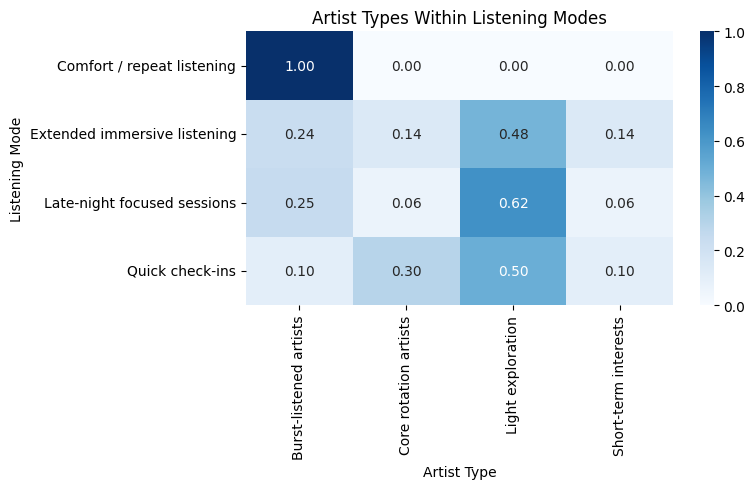

In [44]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot_pct,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)
plt.title("Artist Types Within Listening Modes")
plt.ylabel("Listening Mode")
plt.xlabel("Artist Type")
plt.tight_layout()
plt.show()

By mapping artist engagement clusters to session-level listening modes, I found that exploratory behavior dominates across nearly all listening contexts. Even extended and late-night sessions were driven primarily by light exploration rather than habitual replay. Comfort listening, while limited in volume, was characterized by burst-style engagement, suggesting emotionally driven deep-dives rather than background listening. These results highlight how listening intent varies by context while maintaining a strong exploratory core.